# Chapter 5: Early Stopping and Adaptive Learning Rate
This chapter aims to show how Early Stopping and Adaptive Learning Rate works on a regression task.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

# Define the device, working with numerical data, we decided to use cpu:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

print("Device:", device)

Device: cpu


## Early stopping
Exists multiple early stop criteria based on increase/decrease of a measure (usually loss function) during training/validation.

Here we report a method based on patience. If the validation loss does not decrease for a given number of epochs, the condition is satisfied:

In [2]:
def early_stop_criterion(value_list, warmup_epochs = 5, patience = 5, threshold = 0.01):
    '''
    Return TRUE if the criterion is satisfied:
    The last -patience- elements in the list plut the threshold are higher that the previous value
    value_list [list/numpy array]: List/array of (loss) values to compute early stopping criterion
    warmup_epoch [int=5]: Number of elements to be skipped due to warm up
    patience [int=5]: Number of elements to be evaluated for patience
    threshold [float=0.01]: The threshold value to avoid slowlely decreasing plateau
    '''
    # Define the number of warmup epochs
    warmup_epochs = max(warmup_epochs, patience)
    
    # If the model has been in training for at least warm-up epochs:
    if len(value_list)>warmup_epochs:
        
        # Compute the reference value       
        reference_value = value_list[-patience]
        
        # Define the test_array as the last paticence elements, add threshold to stop the training on plateau
        test_array = np.array(value_list[-(patience-1):])+threshold
        
        # Check boolean condition on all test_array elements
        boolean_stop = np.all(reference_value < test_array)
        
        return boolean_stop
    else:
        return False

Define a synthetic validation loss curve to show the behaviour of the early stop criterion. The red points correspond to the (index - patience) that triggers the criterion.

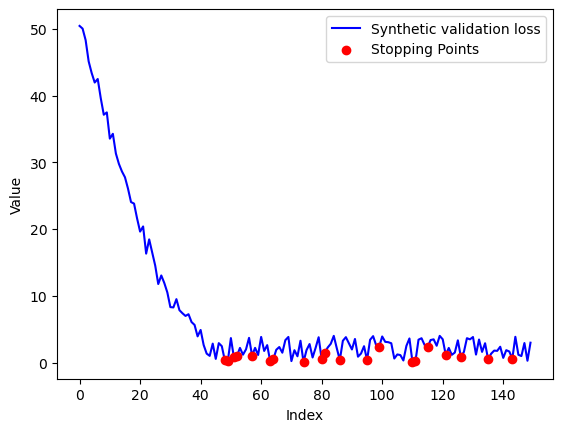

In [3]:
# Synthetic validation curve
epochs = 50
np.random.seed(1902)
example_list = [(epochs-i)**2/epochs if i<epochs else 0 for i in range(epochs+100)]+np.random.rand(epochs+100)*4

# Compute stopping criterion
stopping_list = [early_stop_criterion(example_list[0:i], patience=5, threshold=0.1) for i in range(epochs+100)]

# Plot 
plt.plot(range(epochs + 100), example_list, label="Synthetic validation loss", color='blue')

# Find indices where stopping_list is True
stopping_indices = [i-5 for i, stop in enumerate(stopping_list) if stop]
stopping_values = [example_list[i] for i in stopping_indices]

# Plot red points for True values in stopping_list
plt.scatter(stopping_indices, stopping_values, color='red', label="Stopping Points", zorder=3)

# Labels and legend
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

## Adaptive Learning Rate and Scheduler
The adaptive learning rate is defined using a *scheduler*, which is a module developed to provide at each epoch a different learning rate value used by the optimization algorithm. Pytorch has several built-in adaptive learning rate scheduler, including (StepLR, OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau, ExponentialLR):

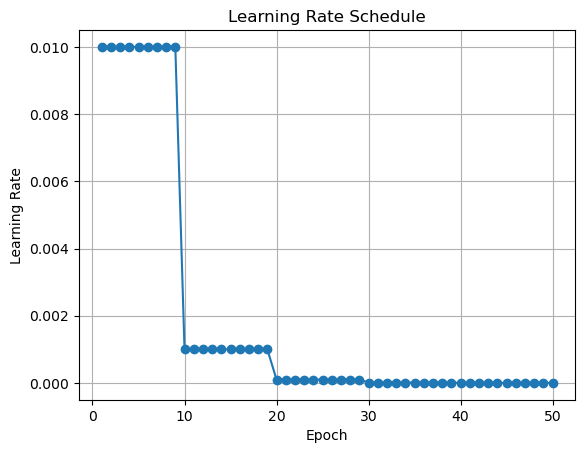

In [4]:
# The scheduler requires an optimiser to be applied to:
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize  the scheduler (this one is a STEP DECAY SCHEDULER) which reduces by a factor gamma the learning rate every step_size epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Show the behaviour on 50 epochs
epochs = 50 

lrs = []
for epoch in range(epochs):
    # Simulate training step
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()

    # Store the current learning rate
    lrs.append(scheduler.get_last_lr()[0])
    
# Plot learning rate
plt.plot(range(1, epochs+1), lrs, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

An alternative approach combining a warm-up phase (i.e. a phase where the model increases the value of the learning rate) and a plateau decrease (to fine tune the model) can be defined using a custom learning rate scheduler.

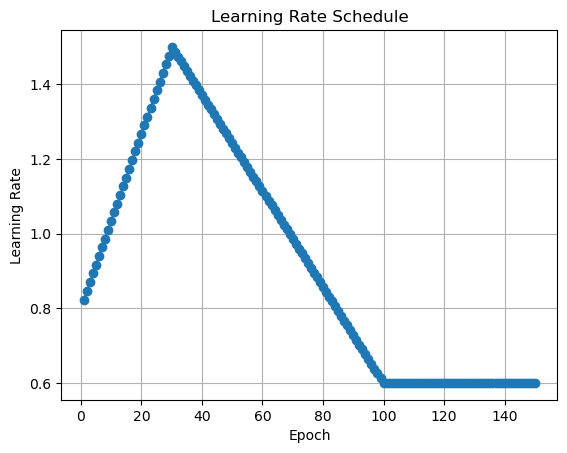

In [5]:
# The scheduler requires an optimiser to be applied to:
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define Custom Scheduler with a triangular shape (warm-up and then learning rate decay):
class CustomLRScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup_epoch, plateau_epoch, initial_lr=1e-3, warmup_lr=1e-1, plateau_lr=1e-5, last_epoch=-1):

        # Ending warm-up epoch
        self.warmup_epoch = warmup_epoch  

        # Plateau training epoch
        self.plateau_epoch = plateau_epoch
        
        # Initial learning rate
        self.initial_lr = initial_lr  

        # Peak learning rate (after warm-up)
        self.warmup_lr = warmup_lr        

        # Plateau learning rate
        self.plateau_lr = plateau_lr

        # Initialize given the optimizer
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        '''Compute new learning rate based on current epoch.'''
        
        current_epoch = self.last_epoch 

        # Warm-up phase
        if current_epoch <= self.warmup_epoch:
            # Linear warmup: Increase learning rate from initial to peak
            factor = current_epoch / self.warmup_epoch
            new_lr = self.initial_lr + (self.warmup_lr - self.initial_lr) * factor
        # Decay phase
        else:
            # Linear decay: Decrease learning rate from peak to plateau epoch
            factor = (self.plateau_epoch - current_epoch) / (self.plateau_epoch - self.warmup_epoch)
            new_lr = self.plateau_lr + (self.warmup_lr - self.plateau_lr) * max(factor, 0)
            
        return [new_lr for _ in self.base_lrs]



# Initialize Custom Scheduler
scheduler = CustomLRScheduler(optimizer, initial_lr=0.8, warmup_lr=1.5, plateau_lr=0.6, warmup_epoch=30, plateau_epoch=100)

# Show the behaviour on 50 epochs
epochs = 150 

lrs = []
for epoch in range(epochs):
    # Simulate training step
    optimizer.step()
    
    # Step the scheduler
    scheduler.step()

    # Store the current learning rate
    lrs.append(scheduler.get_last_lr()[0])
    
# Plot learning rate
plt.plot(range(1, epochs+1), lrs, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

## Standard regression on noisy data:
We define an elementary regression model on noisy data:

In [6]:
chosen_df = "df_nonlinear_heteroscedastic_aleatoric.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

print(len(full_df))

full_df.head(8)

2000


,x_range,y_range,split_label
0,-100.00000,-2.301985,0
1,-99.89995,-1.904300,0
2,-99.79990,-1.670993,2
3,-99.69985,-2.122477,2
4,-99.59980,-1.778223,0
5,-99.49975,-2.057319,1
6,-99.39970,-2.118222,0
7,-99.29965,-2.110165,0


In [7]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])

        features = torch.tensor([x_range], dtype=torch.float32)
        output = torch.tensor([y_range], dtype=torch.float32)
        
        return features, output

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

In [8]:
# Size of each batch
batch_size = 10  

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
# Define the model:
model = nn.Sequential(
    nn.Linear(1, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

We integrate the optimizer with the learning rate scheduler:

In [10]:
# Loss function (Mean Squared Error):
loss_fn = nn.MSELoss()  

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Number of training epochs:
n_epochs = 100
warmup_epoch = 5

# Initialize Custom Scheduler
scheduler = CustomLRScheduler(optimizer, initial_lr=learning_rate, warmup_lr=5*learning_rate, plateau_lr=learning_rate, warmup_epoch=warmup_epoch, plateau_epoch=n_epochs)

Integrate the model with early stopping criterion:

In [11]:
training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  

        # Compute loss (supervised case)
        loss = loss_fn(y_model, y_output)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Step the scheduler
        scheduler.step()

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

            # Forward pass (model calls)
            y_model = model(x_input)

            # Compute loss (supervised case)
            loss = loss_fn(y_model, y_output)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            
    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

    # Check early stopping
    if early_stop_criterion(validation_loss_list, warmup_epochs = 40, patience = 5, threshold = 0.01):
        break

Epoch [1/100], Loss: 0.4948, Val. Loss: 0.3872
Epoch [2/100], Loss: 0.3986, Val. Loss: 0.3362
Epoch [3/100], Loss: 0.3295, Val. Loss: 0.2540
Epoch [4/100], Loss: 0.2323, Val. Loss: 0.1615
Epoch [5/100], Loss: 0.1558, Val. Loss: 0.1294
Epoch [6/100], Loss: 0.1113, Val. Loss: 0.0954
Epoch [7/100], Loss: 0.0904, Val. Loss: 0.0708
Epoch [8/100], Loss: 0.0804, Val. Loss: 0.0810
Epoch [9/100], Loss: 0.0797, Val. Loss: 0.0721
Epoch [10/100], Loss: 0.0723, Val. Loss: 0.0538
Epoch [11/100], Loss: 0.0756, Val. Loss: 0.0640
Epoch [12/100], Loss: 0.0606, Val. Loss: 0.0519
Epoch [13/100], Loss: 0.0601, Val. Loss: 0.0476
Epoch [14/100], Loss: 0.0635, Val. Loss: 0.0936
Epoch [15/100], Loss: 0.0621, Val. Loss: 0.0440
Epoch [16/100], Loss: 0.0494, Val. Loss: 0.0374
Epoch [17/100], Loss: 0.0591, Val. Loss: 0.0378
Epoch [18/100], Loss: 0.0499, Val. Loss: 0.0376
Epoch [19/100], Loss: 0.0555, Val. Loss: 0.0397
Epoch [20/100], Loss: 0.0467, Val. Loss: 0.0349
Epoch [21/100], Loss: 0.0430, Val. Loss: 0.0487
E

As expected, the early stopping criterion avoids wasting too many epochs on an already trained model:

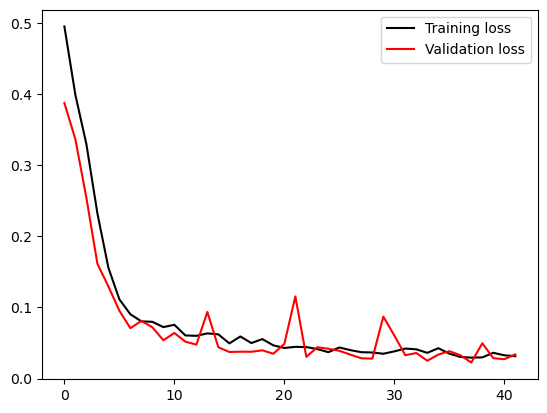

In [12]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

<Axes: xlabel='x', ylabel='y'>

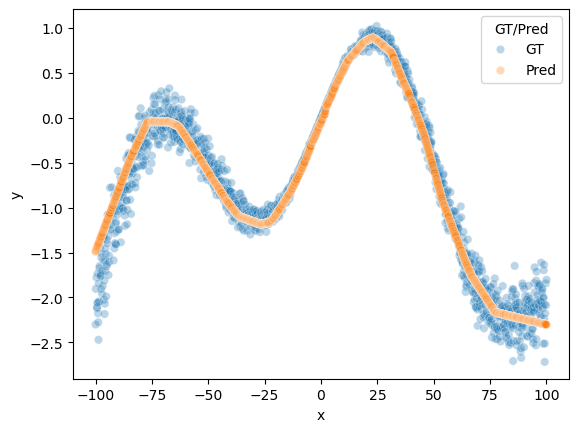

In [13]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"]) # Input
y_plot = np.array(training_df["y_range"]) # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_train = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha = 0.3)